## Setup and Import Libraries

In [1]:
import os
from typing_extensions import TypedDict
from typing import Annotated
from langchain_groq import ChatGroq
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_tavily import TavilySearch
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from pprint import pprint
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [4]:
llm = ChatGroq(model="gemma2-9b-it")

## Creating Arxiv Wrapper

In [5]:
arxiv_api_wrapper = ArxivAPIWrapper(
    top_k_results=2,
    doc_content_chars_max=500
)

arxiv_query_tool = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)

print(arxiv_query_tool.name)

arxiv


In [6]:
arxiv_query_tool.invoke(input="Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

## Creating Wikipedia Wrapper

In [7]:
wikipedia_api_wrapper = WikipediaAPIWrapper(
    top_k_results=2,
    doc_content_chars_max=500
)

wikipedia_query_tool = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)

print(wikipedia_query_tool.name)

wikipedia


In [8]:
wikipedia_query_tool.invoke(input="What is Machine Learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

## Tavily Search Tool

In [9]:
tavily_query_tool = TavilySearch(
    max_results=5,
    topic="general"
)

In [10]:
tavily_query_tool.invoke(input="Provide me the recent update on FIFA World Cup 2026")

{'query': 'Provide me the recent update on FIFA World Cup 2026',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.nbcnews.com/sports/world-cup',
   'title': 'FIFA World Cup 2026: Latest News, Photo and Video',
   'content': 'Trump creates White House task force for the 2026 World Cup. The United States is preparing to co-host the tournament alongside Canada and Mexico.',
   'score': 0.5568099,
   'raw_content': None},
  {'url': 'https://www.roadtrips.com/world-cup/2026-world-cup-packages/schedule/',
   'title': '2026 World Cup Schedule – USA, Canada and Mexico',
   'content': 'The next World Cup will take place from Thursday, June 11 to Sunday, July 19, 2026. The tournament will be hosted across the United States, Canada, and Mexico,',
   'score': 0.5530473,
   'raw_content': None},
  {'url': 'https://www.youtube.com/watch?v=YvTEWX1XvwY',
   'title': '2026 FIFA World Cup tickets go on sale at 8 a.m.',
   'content': 'The World Cup kicks off

## Combining Tools

In [11]:
tools = [arxiv_query_tool, wikipedia_query_tool, tavily_query_tool]

## Binding Tools with LLM

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [13]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'recent AI news', 'time_range': 'day'},
  'id': '9qqncwr0w',
  'type': 'tool_call'}]

In [15]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'c5myhwk9e', 'function': {'arguments': '{"query":"recent AI news","search_depth":"advanced","time_range":"week"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 3303, 'total_tokens': 3407, 'completion_time': 0.189090909, 'prompt_time': 0.067975907, 'queue_time': 0.261042762, 'total_time': 0.257066816}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--15520755-54a5-40c8-b5e1-c40b32d041d9-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent AI news', 'search_depth': 'advanced', 'time_range': 'week'}, 'id': 'c5myhwk9e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 3303, 'output_tokens': 104, 'total_tokens': 3407})

## Create Chatbot with LangGraph

In [16]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [17]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

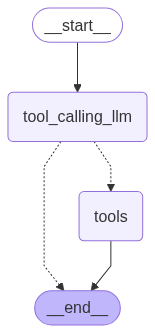

In [18]:
# Build graph
graph_builder = StateGraph(State)

# Add Nodes
graph_builder.add_node(node="tool_calling_llm", action=tool_calling_llm)
graph_builder.add_node(node="tools", action=ToolNode(tools=tools))

# Add Edges
graph_builder.add_edge(start_key=START, end_key="tool_calling_llm")
graph_builder.add_conditional_edges(
    source="tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    path=tools_condition
)
graph_builder.add_edge(start_key="tools", end_key=END)

# Compile Graph
compiled_graph = graph_builder.compile()

# Display Graph
display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [ ]:
# messages = compiled_graph.invoke({"messages":HumanMessage(content="Attention is all you need")})
messages = compiled_graph.invoke({"messages":HumanMessage(content="1706.03762")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (6nqwsspm7)
 Call ID: 6nqwsspm7
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [21]:
messages = compiled_graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (28g14cryn)
 Call ID: 28g14cryn
  Args:
    query: AI news
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest AI News, Analysis & Events", "content": "*   [Categories](https://www.artificialintelligence-news.com/#) *   [AI and Us](https://www.artificialintelligence-news.com/categories/ai-and-us/) *   [World of Work](https://www.artificialintelligence-news.com/categories/ai-and-us/world-of-work/) *   [AI in Action](https://www.artificialintelligence-news.com/categories/ai-in-action/) *   [Creative Industries](https://www

In [22]:
messages = compiled_graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (zmsq6749n)
 Call ID: zmsq6749n
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
